<a href="https://colab.research.google.com/github/7anmay/RL/blob/main/reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Policy Gradients -- Reinforce
- setup policy network
  -- define network layers
  -- define network in forward pass
  -- implement get_action to take in states and give out highest_prob_action and log_prob
  -- update policy function
  -- the main loop

In [ ]:
# Constants
GAMMA = 0.9

class policyNetwork(nn.Module):
  def __init__(self, num_inputs, num_actions, hidden_size, lr=1e-4):
    super(policyNetwork, self).__init__()

    self.num_actions =  num_actions
    self.layer1 = nn.Linear(num_inputs,hidden_size)
    self.layer2 = nn.Linear(hidden_size, num_actions)
    self.optimiser = optim.Adam(self.parameters(), lr=lr)

  def forward(self, state):
    x = F.relu(self.layer1(state))
    x = F.softmax(self.layer2(x))
    return x

  def get_actions(self, state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs= self.forward(Variable(state))
    highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
    log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
    return highest_prob_action, log_prob



def update_policy(policy_network, rewards, log_probs):
  discounted_rewards = []

  for t in range(len(rewards)):
    Gt = 0
    pw = 0
    for r in rewards[t:]:
      Gt += GAMMA ** pw * r
      pw = pw + 1
    discounted_rewards.append(Gt)
  discounted_rewards = torch.tensor(discounted_rewards)
  discounted_rewards = (discounted_rewards - discounted_rewards.mean())/ (discounted_rewards.std() + 1e-9)

  policy_gradient = []
  for log_prob, Gt in zip(log_probs, discounted_rewards):
    policy_gradient.append(-log_prob * Gt)

  policy_network.optimiser.zero_grad()
  policy_gradient = torch.stack(policy_gradient).sum()
  policy_gradient.backward()
  policy_network.optimiser.step()


In [ ]:
def main():
  env = gym.make('CartPole-v0')
  policy_net = policyNetwork(env.observation_space.shape[0], env.action_space.n, 128)

  max_episode_num = 500
  max_steps = 10000
  numsteps = []
  all_rewards = []
  avg_numsteps = []

  for episode in range(max_episode_num):
    state = env.reset()
    log_probs = []
    rewards = []
    for steps in range(max_steps):
      env.render()
      action, log_prob = policy_net.get_actions(state)
      new_state, reward, done, _= env.step(action)
      log_probs.append(log_prob)
      rewards.append(reward)

      if done:
        update_policy(policy_net, rewards, log_probs)
        numsteps.append(steps)
        avg_numsteps.append(np.mean(numsteps[-10:]))
        all_rewards.append(np.sum(rewards))
        if episode % 1 == 0:
            sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
        break

      state = new_state

  plt.plot(numsteps)
  plt.plot(avg_numsteps)
  plt.xlabel('Episode')
  plt.show()


<ipython-input-13-d3f0dc8fb090>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.layer2(x))


episode: 0, total reward: 18.0, average_reward: 18.0, length: 17
episode: 1, total reward: 14.0, average_reward: 16.0, length: 13
episode: 2, total reward: 12.0, average_reward: 14.667, length: 11
episode: 3, total reward: 13.0, average_reward: 14.25, length: 12
episode: 4, total reward: 18.0, average_reward: 15.0, length: 17
episode: 5, total reward: 39.0, average_reward: 19.0, length: 38
episode: 6, total reward: 39.0, average_reward: 21.857, length: 38
episode: 7, total reward: 29.0, average_reward: 22.75, length: 28
episode: 8, total reward: 26.0, average_reward: 23.111, length: 25
episode: 9, total reward: 44.0, average_reward: 25.2, length: 43
episode: 10, total reward: 21.0, average_reward: 25.5, length: 20
episode: 11, total reward: 18.0, average_reward: 25.9, length: 17
episode: 12, total reward: 21.0, average_reward: 26.8, length: 20
episode: 13, total reward: 13.0, average_reward: 26.8, length: 12
episode: 14, total reward: 35.0, average_reward: 28.5, length: 34
episode: 15,

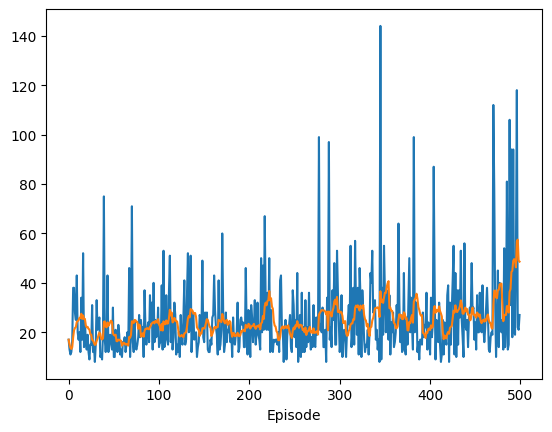

In [ ]:
main()